In [1]:
import pathlib
import re
from typing import Any, Dict, List, Literal, Optional, Tuple, Union

import matplotlib.collections
import numpy as np
np.bool8 = np.bool_

import matplotlib
matplotlib.collections.BrokenBarHCollection = None

import coolbox.api as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnado.api as pn
import pyranges as pr
import seaborn as sns
from plotnado.api import Figure, TrackWrapper

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["svg.fonttype"] = "none"

# ChIP-seq data

In [2]:
patient_number_to_name = {
    "26754": "chALL1",
    "27654": "chALL1",
    "27800": "chALL2",
    "11911": "chALL3",
    "MA4-primograft": "iALL1",
    "2q23": "iALL2",
    "23003": "iALL2",
    "863388": "iALL3",
    "874415": "iALL4",
    "28349": "iALL5",
    "20522": "chALL4",
    "27800": "chALL5",
    "20522": "chALL6",
    "8011": "iALL6",
    "4484": "iALL7",
    "6807": "iALL8",
    "21940": "chALL7",
    "25911": "iALL9",
    "87495": "iALL4",
}

patient_sample_colors = {
    "chALL26754": "#e94d36",
    "chALL11911": "#fbbb10",
    "chALL20522": "#1e5df8",
    "chALL27800": "#67c04d",
    "iALL23003": "#be2bbb",
    "iALL28349": "#00a788",
    "iALL863388": "#ff9d1b",
    "iALL874415": "#4aa5dc",
    "chALL1": "#e94d36",
    "chALL2": "#67c04d",
    "chALL3": "#fbbb10",
    "chALL6": "#1e5df8",
    "chALL5": "#67c04d",
    "iALL2": "#be2bbb",
    "iALL5": "#00a788",
    "iALL3": "#ff9d1b",
    "iALL4": "#4aa5dc",
    "iALL1": "#33A69A",
    "iALL6": "#D93232",
    "iALL7": "#2E62A6",
    "iALL8": "#D99A25",
}

In [3]:
chip_bigwigs_dir1 = pathlib.Path(
    "/home/a/asmith/project_milne_group/Projects/2023-11-21-MLL-AF4_transcriptional_heterogeneity_paper/mll-af4_transcriptional_heterogeneity_paper/data/raw/2024-04-02_chip_mll-af4-heterogeneity-paper-remap/seqnado_output/bigwigs"
)
chip_bigwigs_dir2 = pathlib.Path(
    "/ceph/project/milne_group/asmith/ChIP_seq/2023-11-01-ijun-chip-as-cm-cr-ct/2023-11-2-as-primary-and-cut-and-x/seqnado_output/bigwigs/deeptools"
)

chip_bigwigs = [
    *chip_bigwigs_dir1.rglob("*.bigWig"),
    *chip_bigwigs_dir2.glob("CM*.bigWig"),
]

chip_bigwigs[:5]

[PosixPath('/home/a/asmith/project_milne_group/Projects/2023-11-21-MLL-AF4_transcriptional_heterogeneity_paper/mll-af4_transcriptional_heterogeneity_paper/data/raw/2024-04-02_chip_mll-af4-heterogeneity-paper-remap/seqnado_output/bigwigs/deeptools/unscaled/iALL-28349_PAF1.bigWig'),
 PosixPath('/home/a/asmith/project_milne_group/Projects/2023-11-21-MLL-AF4_transcriptional_heterogeneity_paper/mll-af4_transcriptional_heterogeneity_paper/data/raw/2024-04-02_chip_mll-af4-heterogeneity-paper-remap/seqnado_output/bigwigs/deeptools/unscaled/iALL-863388_AF4-C.bigWig'),
 PosixPath('/home/a/asmith/project_milne_group/Projects/2023-11-21-MLL-AF4_transcriptional_heterogeneity_paper/mll-af4_transcriptional_heterogeneity_paper/data/raw/2024-04-02_chip_mll-af4-heterogeneity-paper-remap/seqnado_output/bigwigs/deeptools/unscaled/chALL-11911-CM_H3K4me1.bigWig'),
 PosixPath('/home/a/asmith/project_milne_group/Projects/2023-11-21-MLL-AF4_transcriptional_heterogeneity_paper/mll-af4_transcriptional_heterogene

### Categorise tracks

In [4]:
chip_tracks = pd.DataFrame(chip_bigwigs, columns=["path"])
chip_tracks["name"] = chip_tracks.path.apply(lambda x: x.stem)
chip_tracks["assay"] = np.where(chip_tracks.name.str.contains("ChIP"), "ChIP", "CM")
chip_tracks["patient"] = chip_tracks.name.str.extract(r"([0-9]+)")
chip_tracks["is_xeno"] = chip_tracks.name.str.contains("Xeno")
chip_tracks["antibody"] = (
    chip_tracks.name.str.replace("_(N|C)", r"-\1")
    .str.split("_")
    .str[-1]
    .str.replace("-\d$", "", regex=True)
    .str.replace("MLLN", "MLL-N")
)
chip_tracks["patient_name"] = chip_tracks.patient.map(patient_number_to_name)

chip_tracks[chip_tracks.antibody.str.contains("H3K27ac")]

# Filter the bigwigs to only include the ones we care about
chip_tracks = chip_tracks.query(
    "~is_xeno and ~antibody.isin(['C', 'N']) and assay == 'CM' and antibody.isin(['H3K27ac', 'MLL-N'])"
).drop_duplicates(subset=["patient_name", "antibody"])

chip_tracks = chip_tracks.sort_values(["patient_name", "antibody"])
chip_tracks

,path,name,assay,patient,is_xeno,antibody,patient_name
102,/home/a/asmith/project_milne_group/Projects/20...,chALL-26754-CM_H3K27ac,CM,26754,False,H3K27ac,chALL1
35,/home/a/asmith/project_milne_group/Projects/20...,chALL-26754-CM_MLLN,CM,26754,False,MLL-N,chALL1
13,/home/a/asmith/project_milne_group/Projects/20...,chALL-11911_H3K27ac,CM,11911,False,H3K27ac,chALL3
18,/home/a/asmith/project_milne_group/Projects/20...,chALL-11911-CM_MLL-N,CM,11911,False,MLL-N,chALL3
94,/home/a/asmith/project_milne_group/Projects/20...,chALL-27800-CM_H3K27ac,CM,27800,False,H3K27ac,chALL5
37,/home/a/asmith/project_milne_group/Projects/20...,chALL-27800_MLLN,CM,27800,False,MLL-N,chALL5
8,/home/a/asmith/project_milne_group/Projects/20...,chALL-20522_H3K27ac,CM,20522,False,H3K27ac,chALL6
27,/home/a/asmith/project_milne_group/Projects/20...,chALL-20522_MLL-N,CM,20522,False,MLL-N,chALL6
80,/home/a/asmith/project_milne_group/Projects/20...,chALL21940_H3K27ac,CM,21940,False,H3K27ac,chALL7
40,/home/a/asmith/project_milne_group/Projects/20...,iALL-23003-CM_H3K27ac,CM,23003,False,H3K27ac,iALL2


### Drop the poor quality tracks (iALL9)

In [5]:
chip_tracks = chip_tracks.query("~patient_name.isin(['iALL9'])")
chip_tracks

,path,name,assay,patient,is_xeno,antibody,patient_name
102,/home/a/asmith/project_milne_group/Projects/20...,chALL-26754-CM_H3K27ac,CM,26754,False,H3K27ac,chALL1
35,/home/a/asmith/project_milne_group/Projects/20...,chALL-26754-CM_MLLN,CM,26754,False,MLL-N,chALL1
13,/home/a/asmith/project_milne_group/Projects/20...,chALL-11911_H3K27ac,CM,11911,False,H3K27ac,chALL3
18,/home/a/asmith/project_milne_group/Projects/20...,chALL-11911-CM_MLL-N,CM,11911,False,MLL-N,chALL3
94,/home/a/asmith/project_milne_group/Projects/20...,chALL-27800-CM_H3K27ac,CM,27800,False,H3K27ac,chALL5
37,/home/a/asmith/project_milne_group/Projects/20...,chALL-27800_MLLN,CM,27800,False,MLL-N,chALL5
8,/home/a/asmith/project_milne_group/Projects/20...,chALL-20522_H3K27ac,CM,20522,False,H3K27ac,chALL6
27,/home/a/asmith/project_milne_group/Projects/20...,chALL-20522_MLL-N,CM,20522,False,MLL-N,chALL6
80,/home/a/asmith/project_milne_group/Projects/20...,chALL21940_H3K27ac,CM,21940,False,H3K27ac,chALL7
40,/home/a/asmith/project_milne_group/Projects/20...,iALL-23003-CM_H3K27ac,CM,23003,False,H3K27ac,iALL2


# Capture-C data

In [6]:
capturec_output = pathlib.Path(
    "~/project_milne_group/CaptureC/2024-03-26-mll-af4-complex-degrade-meta-analysis/capcruncher_output/"
).expanduser()
capturec_output_results = capturec_output / "results"

capturec_bigwigs = list(capturec_output_results.rglob("*norm*/si*.bigWig"))

df_capturec = pd.DataFrame(capturec_bigwigs, columns=["path"])
df_capturec["name"] = df_capturec.path.apply(lambda x: x.stem)
df_capturec["condition"] = df_capturec.name.str.extract(r"si(MM|MA6)")[0].map(
    {"MM": "control", "MA6": "knockdown"}
)
df_capturec["viewpoint"] = (
    df_capturec.name.str.split("_")
    .str[2:]
    .str.join("_")
    .str.replace("_[0-9]$", "", regex=True)
)
df_capturec["replicate"] = df_capturec.name.str.extract(r"_(\d+)_").astype(int)
df_capturec

,path,name,condition,viewpoint,replicate
0,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_2_MEF2C_2,knockdown,MEF2C,2
1,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_2_MED13_2,knockdown,MED13,2
2,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_2_GADD45A,knockdown,GADD45A,2
3,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_2_PROM1_LI,knockdown,PROM1_LI,2
4,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_2_JMJD1C_2,knockdown,JMJD1C,2
...,...,...,...,...,...
205,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_1_TET2_2,knockdown,TET2,1
206,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_1_OGT_1,knockdown,OGT,1
207,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_1_TET2_1,knockdown,TET2,1
208,/home/a/asmith/project_milne_group/CaptureC/20...,siMA6_1_MBNL1_3,knockdown,MBNL1,1


In [7]:
df_capturec["viewpoint"].unique()

array(['MEF2C', 'MED13', 'GADD45A', 'PROM1_LI', 'JMJD1C', 'CDK6', 'SPI1',
       'MBNL1', 'JARID1A', 'ASH2L', 'TAPT1', 'FOS', 'SUPT3H', 'MSL3',
       'SMYD2', 'FLT3', 'MYB', 'TET2', 'SUZ12', 'JUN', 'ELL2', 'BAZ2B',
       'OGT', 'PROM1_SI', 'LMO4', 'ARID1B', 'MYC', 'EP300', 'BCL2',
       'FUT10', 'BCL11A', 'EZH2'], dtype=object)

## Viewpoint coordinates

In [33]:
capturec_viewpoints = pathlib.Path(
    "/ceph/project/milne_group/asmith/CaptureC/2024-03-26-mll-af4-complex-degrade-meta-analysis/set1_viewpoints_hg38.bed"
)
gr_viewpoints = pr.read_bed(capturec_viewpoints.as_posix())
gr_viewpoints.head()

,Chromosome,Start,End,Name,Score
0,chr1,58783427,58785019,JUN,1
1,chr1,67684383,67686088,GADD45A,1
2,chr1,87328201,87329677,LMO4_1,1
3,chr1,214280721,214282892,SMYD2_1,1
4,chr2,60551796,60555313,BCL11A,1
5,chr2,159615654,159616401,BAZ2B_2,1
6,chr3,152268423,152268638,MBNL1_2,1
7,chr3,152268635,152271482,MBNL1_3,1


## SEM ChIP-seq data

In [8]:
h3k27ac_bigwigs = dict(
    control="/ceph/project/milne_group/asmith/ChIP_seq/2024-08-27-mll-af4-kd-remap/seqnado_output/bigwigs/SEM-siMM_H3K27ac.bigWig",
    knockdown="/ceph/project/milne_group/asmith/ChIP_seq/2024-08-27-mll-af4-kd-remap/seqnado_output/bigwigs/SEM-siMA6_H3K27ac.bigWig",
)

sem_archive_data = list(
    pathlib.Path(
        "/ceph/project/milne_group/shared/seqnado_archive/chip_seq/2024-02-01_chip_sem_archive/seqnado_output/bigwigs/deeptools/unscaled"
    ).glob("*.bigWig")
)
df_archive = pd.DataFrame(sem_archive_data, columns=["path"])
df_archive["name"] = df_archive.path.apply(lambda x: x.stem)
df_archive["antibody"] = df_archive.name.str.split("_").str[-1].str.upper()

# Filter the bigwigs to only include the ones we care about
df_archive = df_archive.query("antibody.isin(['MLLN', 'AF4C'])")
df_archive

,path,name,antibody
34,/ceph/project/milne_group/shared/seqnado_archi...,sem-mlln_mlln,MLLN
40,/ceph/project/milne_group/shared/seqnado_archi...,sem-af4c_af4c,AF4C


# Enhancers

In [9]:
df_enhancers = pd.read_csv(
    "../../data/processed/compare-sem-vs-rs411-enhancers/sem_vs_rs411_enhancer_diff.csv"
)
df_enhancers.head()

,Name,Chromosome,Start,End,Strand,Length,SEM_B11_2.bam,RS411_A8_1.bam,RS411_C10_1.bam,SEM_B9_2.bam,...,RS411_A6_2.bam,RS411_A4_2.bam,SEM_C6_2.bam,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cell_line_diff
0,chr1:841706-842572,chr1,841706,842572,+,867,10,9,7,8,...,4,15,14,12.801521,0.008681,0.297649,0.033458,9.733094e-01,9.830994e-01,Unchanged
1,chr1:1143877-1144871,chr1,1143877,1144871,+,995,20,6,4,8,...,10,15,22,14.190308,0.680930,0.297003,2.604028,9.213530e-03,2.427863e-02,SEM
2,chr1:1462580-1462664,chr1,1462580,1462664,+,85,0,5,2,1,...,6,2,2,1.702980,-2.514725,0.881660,-3.500542,4.643130e-04,1.867051e-03,RS411
3,chr1:1504695-1506091,chr1,1504695,1506091,+,1397,38,36,29,40,...,21,49,57,43.523273,0.405963,0.172596,2.474562,1.333998e-02,3.327607e-02,SEM
4,chr1:2025378-2028962,chr1,2025378,2028962,+,3585,23,51,37,13,...,46,46,26,37.047497,-1.298189,0.215781,-6.275839,3.477543e-10,5.654622e-09,RS411


In [10]:
gr_enhancers = pr.PyRanges(df_enhancers)
gr_enhancers_sem = gr_enhancers.df.query("cell_line_diff == 'SEM'").pipe(pr.PyRanges)
gr_enhancers_sem.merge(slack=5000).to_bed("sem_enhancers.bed", keep=False)

# Plot

In [48]:
exclusion_regions = gr_viewpoints.slack(1000).to_bed('exclusion_regions.bed', keep=False)

In [49]:
def get_color(x, sample_colors):
    return sample_colors.get(x, "black")


def get_capturec_track(
    tracks: pd.DataFrame, viewpoint: str, condition: str, **kwargs
) -> TrackWrapper:
    tracks = tracks.query(f"viewpoint == '{viewpoint}' and condition == '{condition}'")

    if len(tracks) == 0:
        raise ValueError(
            f"No tracks found for viewpoint {viewpoint} and condition {condition}"
        )

    track_paths = tracks.path.tolist()
    aggregated_track = TrackWrapper("bigwig_fragment_collection", track_paths, **kwargs)
    return aggregated_track

In [50]:
sample_colors = {
    **patient_sample_colors,
    **{"control": "grey", "knockdown": "red", "SEM": "#2a4b9b"},
}

In [51]:
VIEWPOINT = "ARID1B"

In [52]:
!mkdir -p genome_browser_figures

[W::hts_idx_load3] The index file is older than the data file: /home/a/asmith/project_milne_group/Projects/plotnado/plotnado/data/gene_bed_files/hg38_genes.bed.bgz.tbi
2024-09-04 14:09:36.148 | DEBUG    | plotnado.api.genes:__get_length_w:49 - len of w set to: 5638.336073059361 bp
2024-09-04 14:09:36.622 | DEBUG    | plotnado.api.genes:plot_genes:199 - ylim 100,0


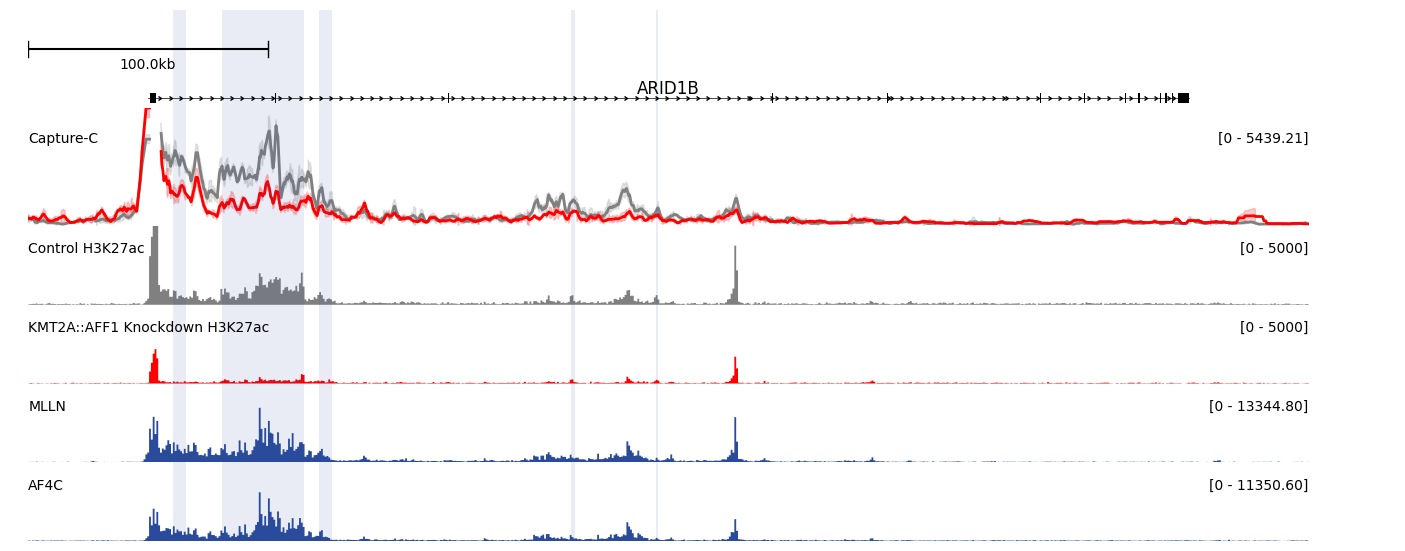

In [53]:
fig = Figure(
    autospacing=True,
    highlight_regions="sem_enhancers.bed",
    highlight_regions_color=sample_colors["SEM"],
    highlight_regions_kwargs={"alpha": 0.1},
)


# Standard tracks
fig.add_track("scale")
fig.add_track(
    "genes",
    file="/home/a/asmith/project_milne_group/Projects/plotnado/plotnado/data/gene_bed_files/hg38_genes.bed",
    genome="hg38",
    gene_style="normal",
    min_gene_length=int(1.2e5),
    height=0.5,
    label_y_offset=-50,
    label_loc="mid",
    arrow_color="black",
)


control_interactions = get_capturec_track(
    df_capturec,
    viewpoint=VIEWPOINT,
    condition="control",
    color=get_color("control", sample_colors),
    title="Control",
    smooth=True,
    smooth_window=2001,
    exclusions="exclusion_regions.bed",
    
)
knockdown_interactions = get_capturec_track(
    df_capturec,
    viewpoint=VIEWPOINT,
    condition="knockdown",
    color=get_color("knockdown", sample_colors),
    title="Knockdown",
    smooth=True,
    smooth_window=2001,
    exclusions="exclusion_regions.bed",
)

overlay = TrackWrapper(
    "bigwig_overlay",
    [control_interactions, knockdown_interactions],
    data_range_style="text",
    data_range_location="right",
    label_on_track=True,
    title="Capture-C",
)
fig.add_track(overlay)


# # ChIP tracks
control_h3k27ac = TrackWrapper(
    "bigwig",
    h3k27ac_bigwigs["control"],
    style="stairsfilled",
    color=get_color("control", sample_colors),
    title="Control H3K27ac",
    data_range_style="text",
    data_range_location="right",
    label_on_track=True,
    label_loc="left",
    max_value=5000,
)
knockdown_h3k27ac = TrackWrapper(
    "bigwig",
    h3k27ac_bigwigs["knockdown"],
    style="stairsfilled",
    color=get_color("knockdown", sample_colors),
    title="KMT2A::AFF1 Knockdown H3K27ac",
    data_range_style="text",
    data_range_location="right",
    label_on_track=True,
    label_loc="left",
    max_value=5000,
)

fig.add_track(control_h3k27ac)
fig.add_track(knockdown_h3k27ac)


for track in df_archive.itertuples():
    fig.add_track(
        "bigwig",
        file=str(track.path),
        style="stairsfilled",
        color=get_color("SEM", sample_colors),
        title=f"{track.antibody}",
        data_range_style="text",
        data_range_location="right",
        label_on_track=True,
        label_loc="left",
        autoscale_group=track.antibody,
    )

# # Add genomic axis
# fig.add_track("xaxis")

f = fig.plot_gene(
    VIEWPOINT,
    "/home/a/asmith/project_milne_group/Projects/plotnado/plotnado/data/genes/hg38.json",
    extend=int(5e4),
)

f.savefig(f"genome_browser_figures/{VIEWPOINT}.svg", bbox_inches="tight")
f

# Repeat for other regions

In [58]:
def get_plot(
    viewpoint: str,
    capturec_tracks: pd.DataFrame,
    h3k27ac_tracks: Dict[str, str],
    archive_tracks: pd.DataFrame,
    highlight: Optional[cb.HighLights] =None,
    max_value_chip: Optional[int] = 5000,
    smooth_window: Optional[int] = 2001,
    min_gene_length: Optional[int] = int(1.2e5),
    gene_y_offset: Optional[int] = -50,
) -> Figure:
    
    fig = Figure(autospacing=True, 
                highlight_regions="sem_enhancers.bed",
                highlight_regions_color=sample_colors["SEM"],
                highlight_regions_kwargs={"alpha": 0.1},
                )

    # Standard tracks
    fig.add_track("scale")
    fig.add_track(
        "genes",
        genome="hg38",
        gene_style="normal",
        min_gene_length=min_gene_length,
        height=0.5,
        label_y_offset=gene_y_offset,
        label_loc="mid",
        arrow_color="black",
    )

    control_interactions = get_capturec_track(
        df_capturec,
        viewpoint=viewpoint,
        condition="control",
        color=get_color("control", sample_colors),
        title="Control",
        smooth=True,
        smooth_window=smooth_window,
        exclusions="exclusion_regions.bed",
    )
    knockdown_interactions = get_capturec_track(
        df_capturec,
        viewpoint=viewpoint,
        condition="knockdown",
        color=get_color("knockdown", sample_colors),
        title="Knockdown",
        smooth=True,
        smooth_window=smooth_window,
        exclusions="exclusion_regions.bed",
    )

    overlay = TrackWrapper(
        "bigwig_overlay",
        [control_interactions, knockdown_interactions],
        data_range_location="right",
    )
    fig.add_track(overlay)

    # # ChIP tracks
    control_h3k27ac = TrackWrapper(
        "bigwig",
        h3k27ac_bigwigs["control"],
        style="stairsfilled",
        color=get_color("control", sample_colors),
        title="Control H3K27ac",
        data_range_style="text",
        data_range_location="right",
        label_on_track=True,
        label_loc="left",
        max_value=max_value_chip,
    )
    knockdown_h3k27ac = TrackWrapper(
        "bigwig",
        h3k27ac_bigwigs["knockdown"],
        style="stairsfilled",
        color=get_color("knockdown", sample_colors),
        title="KMT2A::AFF1 Knockdown H3K27ac",
        data_range_style="text",
        data_range_location="right",
        label_on_track=True,
        label_loc="left",
        max_value=max_value_chip,
    )

    fig.add_track(control_h3k27ac)
    fig.add_track(knockdown_h3k27ac)

    for track in df_archive.itertuples():
        fig.add_track(
            "bigwig",
            file=str(track.path),
            style="stairsfilled",
            color=get_color("SEM", sample_colors),
            title=f"{track.antibody}",
            data_range_style="text",
            data_range_location="right",
            label_on_track=True,
            label_loc="left",
            autoscale_group=track.antibody,
        )

    return fig

In [59]:
viewpoints = df_capturec.viewpoint.unique()
viewpoints

array(['MEF2C', 'MED13', 'GADD45A', 'PROM1_LI', 'JMJD1C', 'CDK6', 'SPI1',
       'MBNL1', 'JARID1A', 'ASH2L', 'TAPT1', 'FOS', 'SUPT3H', 'MSL3',
       'SMYD2', 'FLT3', 'MYB', 'TET2', 'SUZ12', 'JUN', 'ELL2', 'BAZ2B',
       'OGT', 'PROM1_SI', 'LMO4', 'ARID1B', 'MYC', 'EP300', 'BCL2',
       'FUT10', 'BCL11A', 'EZH2'], dtype=object)

## JMJD1C

JMJD1C


[W::hts_idx_load3] The index file is older than the data file: /ceph/project/milne_group/asmith/Projects/plotnado/plotnado/data/gene_bed_files/hg38_genes.bed.bgz.tbi
2024-09-04 14:10:53.589 | DEBUG    | plotnado.api.genes:__get_length_w:49 - len of w set to: 4793.904690743047 bp
2024-09-04 14:10:53.829 | DEBUG    | plotnado.api.genes:plot_genes:199 - ylim 100,0


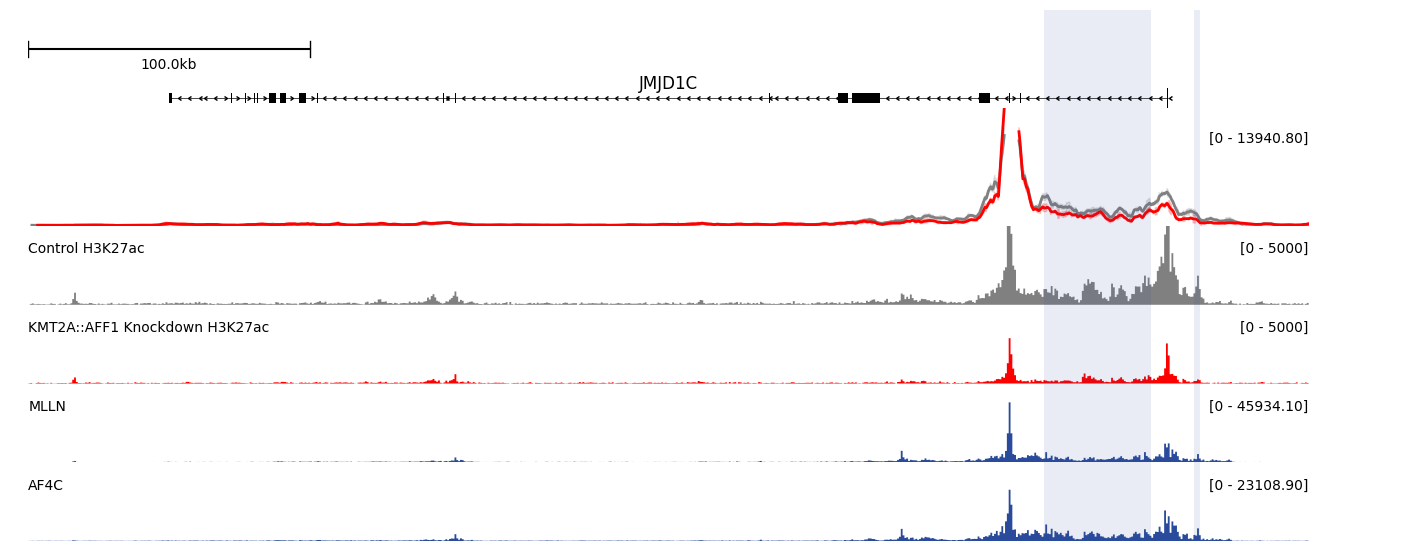

In [60]:
VIEWPOINT_NUMBER = 4
VIEWPOINT = viewpoints[VIEWPOINT_NUMBER]
print(VIEWPOINT)
fig = get_plot(
    VIEWPOINT, df_capturec, h3k27ac_bigwigs, df_archive, smooth_window=3001, gene_y_offset=-75
)
f = fig.plot_gene(VIEWPOINT, "hg38", extend=int(5e4))
f.savefig(f"genome_browser_figures/{VIEWPOINT}.svg", bbox_inches="tight")
f

## MBNL1

MBNL1


[W::hts_idx_load3] The index file is older than the data file: /ceph/project/milne_group/asmith/Projects/plotnado/plotnado/data/gene_bed_files/hg38_genes.bed.bgz.tbi
2024-09-04 14:12:15.561 | DEBUG    | plotnado.api.genes:__get_length_w:49 - len of w set to: 3607.548609381486 bp
2024-09-04 14:12:16.349 | DEBUG    | plotnado.api.genes:plot_genes:199 - ylim 100,0


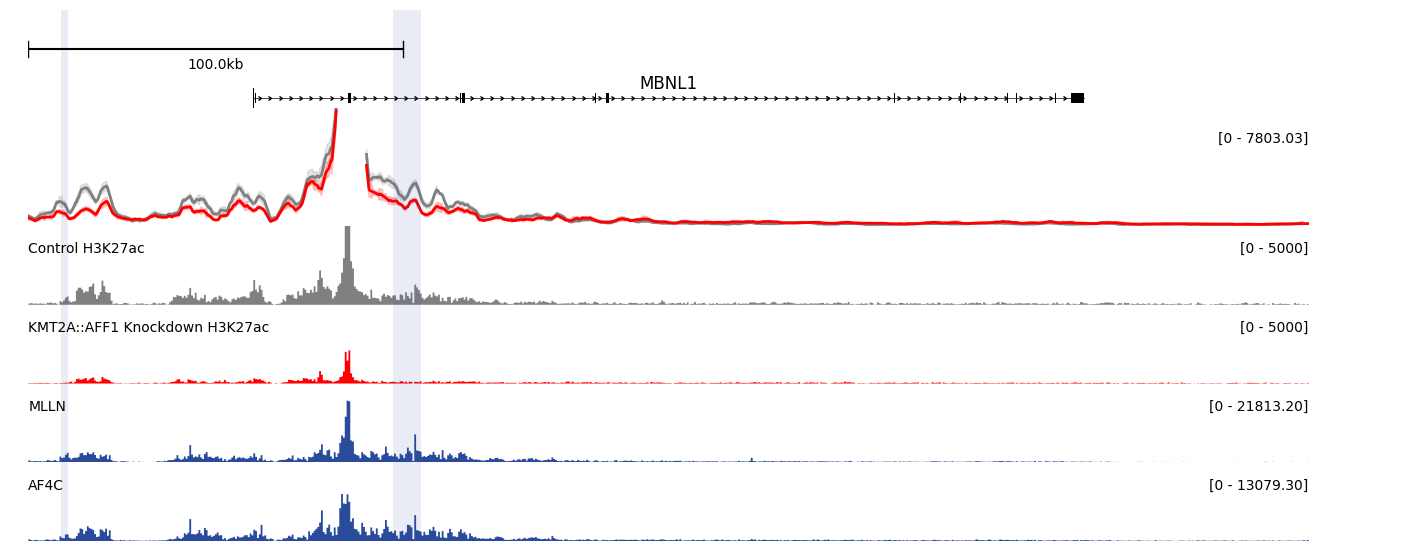

In [63]:
VIEWPOINT_NUMBER = 7
VIEWPOINT = viewpoints[VIEWPOINT_NUMBER]
print(VIEWPOINT)
fig = get_plot(
    VIEWPOINT, df_capturec, h3k27ac_bigwigs, df_archive, smooth_window=3001, gene_y_offset=-75
)
f = fig.plot_gene(VIEWPOINT, "hg38", extend=int(6e4))
f.savefig(f"genome_browser_figures/{VIEWPOINT}.svg", bbox_inches="tight")
f

FLT3


[W::hts_idx_load3] The index file is older than the data file: /ceph/project/milne_group/asmith/Projects/plotnado/plotnado/data/gene_bed_files/hg38_genes.bed.bgz.tbi
2024-09-04 14:14:23.293 | DEBUG    | plotnado.api.genes:__get_length_w:49 - len of w set to: 3240.139559983396 bp
2024-09-04 14:14:23.621 | DEBUG    | plotnado.api.genes:plot_genes:199 - ylim 100,0


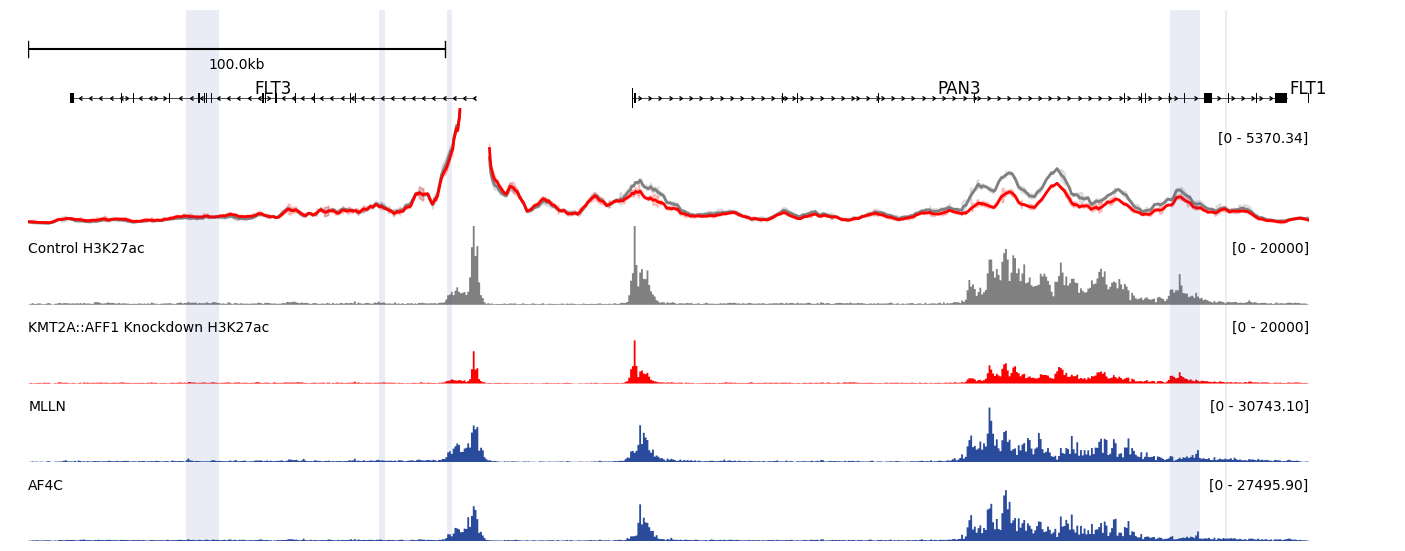

In [66]:
VIEWPOINT_NUMBER = 15
VIEWPOINT = viewpoints[VIEWPOINT_NUMBER]
print(VIEWPOINT)
fig = get_plot(
    VIEWPOINT,
    df_capturec,
    h3k27ac_bigwigs,
    df_archive,
    smooth_window=4001,
    min_gene_length=int(1e4),
    max_value_chip=20_000,
)
f = fig.plot_gene(VIEWPOINT, "hg38", extend={'downstream': int(2e5), 'upstream': int(1e4)})
f.savefig(f"genome_browser_figures/{VIEWPOINT}.svg", bbox_inches="tight")
f